# Data Cleaning, Merging, and EDA

In [23]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
# read in csv of metada
metadata_df = pd.read_csv('skin_metadata.csv')
metadata_df.head()

<ipython-input-2-285ef3b17ea2>:2: DtypeWarning: Columns (14,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv('skin_metadata.csv')


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,diagnosis,...,image_type,lesion_id,mel_class,mel_mitotic_index,mel_thick_mm,mel_type,nevus_type,patient_id,sex,tbp_tile_type
0,ISIC_0015670,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,60.0,lower extremity,benign,3.04,NaN,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_1235828,male,3D: white
1,ISIC_0015845,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,60.0,head/neck,benign,1.10,NaN,NaN,...,TBP tile: close-up,IL_6727506,NaN,NaN,NaN,NaN,NaN,IP_8170065,male,3D: white
2,ISIC_0015864,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,60.0,posterior torso,benign,3.40,NaN,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_6724798,male,3D: XP
3,ISIC_0015902,Courtesy of ACEMID MIA,CC-0,27813.0,65.0,anterior torso,benign,3.22,False,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_4111386,male,3D: XP
4,ISIC_0024200,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,55.0,anterior torso,benign,2.73,NaN,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_8313778,male,3D: white


In [3]:
metadata_df.columns

Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'benign_malignant',
       'clin_size_long_diam_mm', 'concomitant_biopsy', 'diagnosis',
       'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4',
       'diagnosis_5', 'diagnosis_confirm_type', 'image_type', 'lesion_id',
       'mel_class', 'mel_mitotic_index', 'mel_thick_mm', 'mel_type',
       'nevus_type', 'patient_id', 'sex', 'tbp_tile_type'],
      dtype='object')

In [4]:
# inspect anatomical site
metadata_df['anatom_site_general'].unique()

array(['lower extremity', 'head/neck', 'posterior torso',
       'anterior torso', 'upper extremity', nan], dtype=object)

In [5]:
# inspect diagnosis
metadata_df['diagnosis'].unique()

array([nan, 'lichenoid keratosis', 'nevus', 'squamous cell carcinoma',
       'basal cell carcinoma', 'actinic keratosis',
       'seborrheic keratosis', 'atypical melanocytic proliferation',
       'melanoma', 'pigmented benign keratosis', 'solar lentigo',
       'dermatofibroma', 'AIMP', 'other',
       'angiofibroma or fibrous papule', 'scar', 'lentigo NOS',
       'melanoma metastasis', 'verruca', 'angioma', 'adnexal tumor',
       'acrochordon'], dtype=object)

In [6]:
# inspect benign_malignant
metadata_df['benign_malignant'].unique()

array(['benign', 'malignant', 'indeterminate'], dtype=object)

In [21]:
# open and extract image data
import zipfile

zip_file_path = 'ISIC-images.zip'
extract_folder = 'ISIC-images'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_folder)

print(f'Files extracted to {extract_folder}')

Files extracted to ISIC-images


In [24]:
# add file_path column to use for mergin with image labels
metadata_df['file_path'] = metadata_df['isic_id'].apply(lambda x: os.path.join(extract_folder, x + '.jpg'))
metadata_df['file_path'] = metadata_df['file_path'].astype(str)
file_paths = metadata_df['file_path'].tolist()
labels = metadata_df['benign_malignant'].tolist()

image_ds = tf.data.Dataset.from_tensor_slices(file_paths)

def parse_image(filename, target_size = (224, 224)):
  image = tf.io.read_file(filename)
  image = tf.image.decode_image(image, channels = 3)
  image = tf.ensure_shape(image, [None, None, 3])
  image = tf.image.resize(image, target_size)
  image = image / 255.0
  return image

In [26]:
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
image_ds = image_ds.map(lambda x: parse_image(x), num_parallel_calls = tf.data.AUTOTUNE)

In [27]:
combined_ds = tf.data.Dataset.zip((image_ds, labels_ds))

In [7]:
# create dataset containg just men
men_df = metadata_df[metadata_df['sex'] == 'male']
men_df.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,diagnosis,...,image_type,lesion_id,mel_class,mel_mitotic_index,mel_thick_mm,mel_type,nevus_type,patient_id,sex,tbp_tile_type
0,ISIC_0015670,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,60.0,lower extremity,benign,3.04,NaN,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_1235828,male,3D: white
1,ISIC_0015845,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,60.0,head/neck,benign,1.10,NaN,NaN,...,TBP tile: close-up,IL_6727506,NaN,NaN,NaN,NaN,NaN,IP_8170065,male,3D: white
2,ISIC_0015864,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,60.0,posterior torso,benign,3.40,NaN,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_6724798,male,3D: XP
3,ISIC_0015902,Courtesy of ACEMID MIA,CC-0,27813.0,65.0,anterior torso,benign,3.22,False,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_4111386,male,3D: XP
4,ISIC_0024200,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,55.0,anterior torso,benign,2.73,NaN,NaN,...,TBP tile: close-up,NaN,NaN,NaN,NaN,NaN,NaN,IP_8313778,male,3D: white


In [8]:
# drop unnecessary columns
men_df = men_df.drop(columns = ['attribution', 'copyright_license', 'acquisition_day',
                                'clin_size_long_diam_mm', 'concomitant_biopsy', 'diagnosis',
                                'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4',
                                'diagnosis_5', 'diagnosis_confirm_type', 'image_type', 'lesion_id',
                                'mel_class', 'mel_mitotic_index', 'mel_thick_mm', 'mel_type',
                                'nevus_type', 'patient_id', 'tbp_tile_type'])

In [9]:
# check for missing values
men_df.isnull().sum()

,0
isic_id,0
age_approx,137
anatom_site_general,4474
benign_malignant,0
sex,0


In [11]:
# drop rows with missing age
filtered_df = men_df.dropna()

In [12]:
# create dataset of men aged 20-49
younger_df = filtered_df[(filtered_df['age_approx'] >= 20) & (filtered_df['age_approx'] < 50)]
younger_df.head()

,isic_id,age_approx,anatom_site_general,benign_malignant,sex
30,ISIC_0052259,45.0,anterior torso,benign,male
32,ISIC_0052310,45.0,posterior torso,benign,male
58,ISIC_0073521,40.0,anterior torso,benign,male
59,ISIC_0073522,30.0,anterior torso,benign,male
61,ISIC_0073642,45.0,upper extremity,benign,male


In [13]:
younger_df.describe()

,age_approx
count,42293.000000
mean,39.094649
std,5.620771
min,20.000000
25%,35.000000
50%,40.000000
75%,45.000000
max,45.000000


In [28]:
# add file_path to younger dataset for image merge
younger_df['file_path'] = younger_df['isic_id'].apply(lambda x: os.path.join(extract_folder, x + '.jpg'))
younger_df['file_path'] = younger_df['file_path'].astype(str)

file_paths = younger_df['file_path'].tolist()
labels = younger_df['benign_malignant'].tolist()

image_ds = tf.data.Dataset.from_tensor_slices(file_paths)

def parse_image(filename, target_size = (224, 224)):
  image = tf.io.read_file(filename)
  image = tf.image.decode_image(image, channels = 3)
  image = tf.ensure_shape(image, [None, None, 3])
  image = tf.image.resize(image, target_size)
  image = image / 255.0
  return image

<ipython-input-28-0af7aba00769>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  younger_df['file_path'] = younger_df['isic_id'].apply(lambda x: os.path.join(extract_folder, x + '.jpg'))
<ipython-input-28-0af7aba00769>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  younger_df['file_path'] = younger_df['file_path'].astype(str)


In [29]:
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
image_ds = image_ds.map(lambda x: parse_image(x), num_parallel_calls = tf.data.AUTOTUNE)

In [30]:
younger_ds = tf.data.Dataset.zip((image_ds, labels_ds))

In [33]:
# confirm shape
for image_batch, label_batch in younger_ds.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(224, 224, 3)
()


In [14]:
# create dataset for older generation 50-79
older_df = filtered_df[(filtered_df['age_approx'] >= 50) & (filtered_df['age_approx'] < 80)]
older_df.head()

,isic_id,age_approx,anatom_site_general,benign_malignant,sex
0,ISIC_0015670,60.0,lower extremity,benign,male
1,ISIC_0015845,60.0,head/neck,benign,male
2,ISIC_0015864,60.0,posterior torso,benign,male
3,ISIC_0015902,65.0,anterior torso,benign,male
4,ISIC_0024200,55.0,anterior torso,benign,male


In [15]:
older_df.describe()

,age_approx
count,195009.000000
mean,62.044957
std,7.948608
min,50.000000
25%,55.000000
50%,60.000000
75%,70.000000
max,75.000000


In [34]:
# repeat for older data
older_df['file_path'] = older_df['isic_id'].apply(lambda x: os.path.join(extract_folder, x + '.jpg'))
older_df['file_path'] = older_df['file_path'].astype(str)

image_ds = tf.data.Dataset.from_tensor_slices(file_paths)

def parse_image(filename, target_size = (224, 224)):
  image = tf.io.read_file(filename)
  image = tf.image.decode_image(image, channels = 3)
  image = tf.ensure_shape(image, [None, None, 3])
  image = tf.image.resize(image, target_size)
  image = image / 255.0
  return image

<ipython-input-34-c9f35d2865ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  older_df['file_path'] = older_df['isic_id'].apply(lambda x: os.path.join(extract_folder, x + '.jpg'))
<ipython-input-34-c9f35d2865ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  older_df['file_path'] = older_df['file_path'].astype(str)


In [35]:
label_ds = tf.data.Dataset.from_tensor_slices(labels)
image_ds = image_ds.map(lambda x: parse_image(x), num_parallel_calls = tf.data.AUTOTUNE)

In [36]:
older_ds = tf.data.Dataset.zip((image_ds, labels_ds))

In [37]:
for image_batch, label_batch in older_ds.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(224, 224, 3)
()


# Younger Data EDA

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
younger_df.head()

,isic_id,age_approx,anatom_site_general,benign_malignant,sex,file_path
30,ISIC_0052259,45.0,anterior torso,benign,male,ISIC-images/ISIC_0052259.jpg
32,ISIC_0052310,45.0,posterior torso,benign,male,ISIC-images/ISIC_0052310.jpg
58,ISIC_0073521,40.0,anterior torso,benign,male,ISIC-images/ISIC_0073521.jpg
59,ISIC_0073522,30.0,anterior torso,benign,male,ISIC-images/ISIC_0073522.jpg
61,ISIC_0073642,45.0,upper extremity,benign,male,ISIC-images/ISIC_0073642.jpg


In [ ]:
younger_df.describe()

,age_approx,target
count,42293.000000,42293.000000
mean,39.094649,0.000567
std,5.620771,0.023815
min,20.000000,0.000000
25%,35.000000,0.000000
50%,40.000000,0.000000
75%,45.000000,0.000000
max,45.000000,1.000000


In [ ]:
younger_df['target'].value_counts()

,count
target,
0,42269
1,24


In [ ]:
younger_df['anatom_site_general'].value_counts()

,count
anatom_site_general,
posterior torso,14250
lower extremity,10200
upper extremity,8294
anterior torso,8080
head/neck,1469


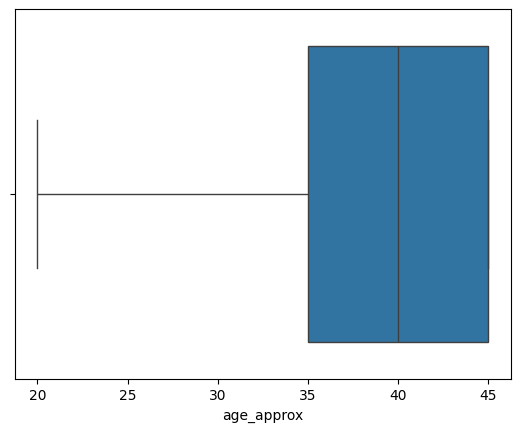

In [ ]:
sns.boxplot(x = younger_df['age_approx'])
plt.show()

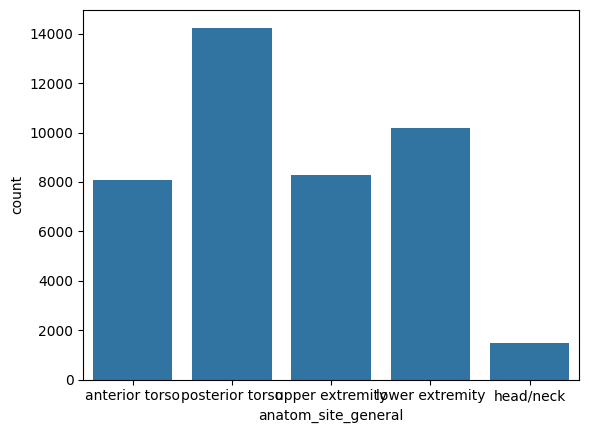

In [ ]:
sns.countplot(x = 'anatom_site_general', data = younger_df)
plt.show()

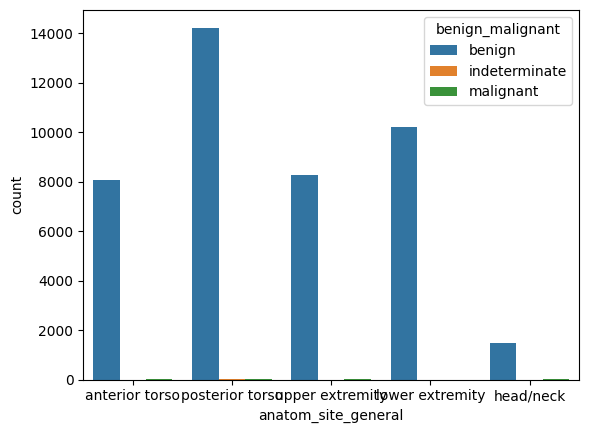

In [ ]:
sns.countplot(x = 'anatom_site_general', hue = 'benign_malignant', data = younger_df)
plt.show()

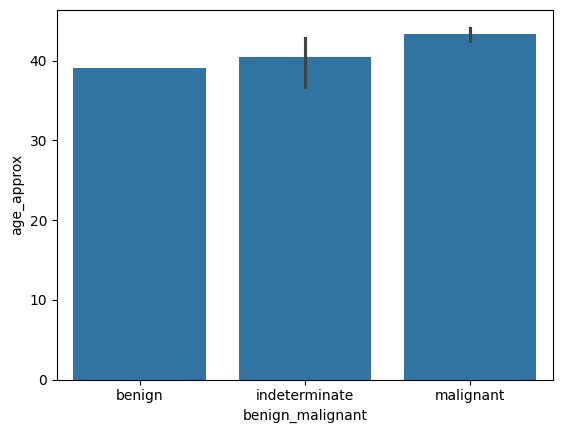

In [ ]:
sns.barplot(x = 'benign_malignant', y = 'age_approx', data = younger_df)
plt.show()

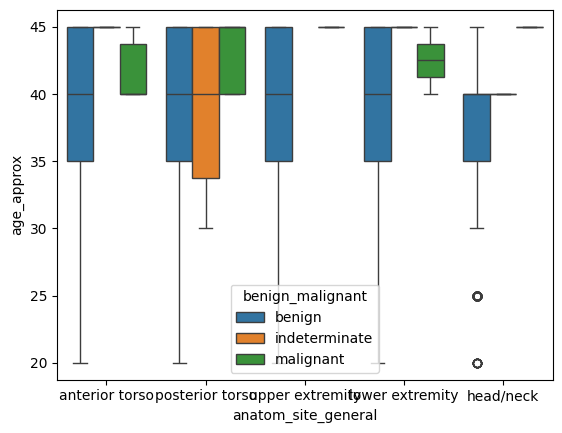

In [ ]:
sns.boxplot(x = 'anatom_site_general', y = 'age_approx', hue = 'benign_malignant', data = younger_df)
plt.show()

# Older Data EDA

In [ ]:
older_df.head()

,isic_id,age_approx,anatom_site_general,benign_malignant,file_path,target
0,ISIC_0015670,60,lower extremity,benign,ISIC-images/ISIC_0015670.jpg,0
1,ISIC_0015845,60,head/neck,benign,ISIC-images/ISIC_0015845.jpg,0
2,ISIC_0015864,60,posterior torso,benign,ISIC-images/ISIC_0015864.jpg,0
3,ISIC_0015902,65,anterior torso,benign,ISIC-images/ISIC_0015902.jpg,0
4,ISIC_0024200,55,anterior torso,benign,ISIC-images/ISIC_0024200.jpg,0


In [ ]:
older_df.describe()

,age_approx,target
count,195009.000000,195009.000000
mean,62.044957,0.001113
std,7.948608,0.033340
min,50.000000,0.000000
25%,55.000000,0.000000
50%,60.000000,0.000000
75%,70.000000,0.000000
max,75.000000,1.000000


In [ ]:
older_df['target'].value_counts()

,count
target,
0,194792
1,217


In [ ]:
older_df['anatom_site_general'].value_counts()

,count
anatom_site_general,
posterior torso,62821
anterior torso,47371
lower extremity,46926
upper extremity,31701
head/neck,6190


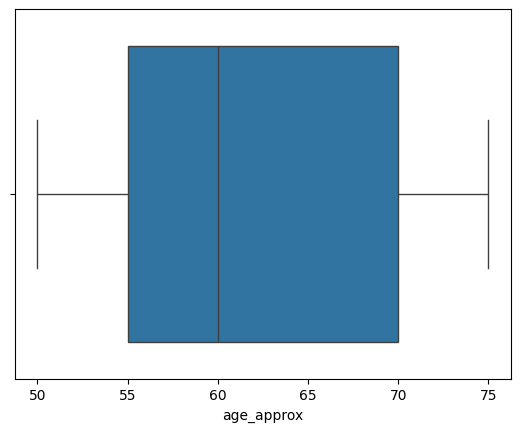

In [ ]:
sns.boxplot(x = older_df['age_approx'])
plt.show()

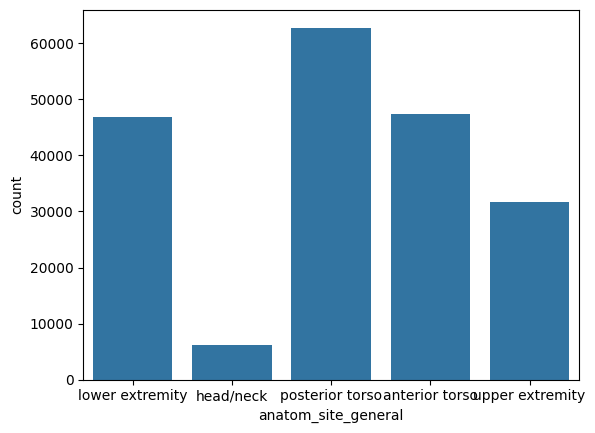

In [ ]:
sns.countplot(x = 'anatom_site_general', data = older_df)
plt.show()

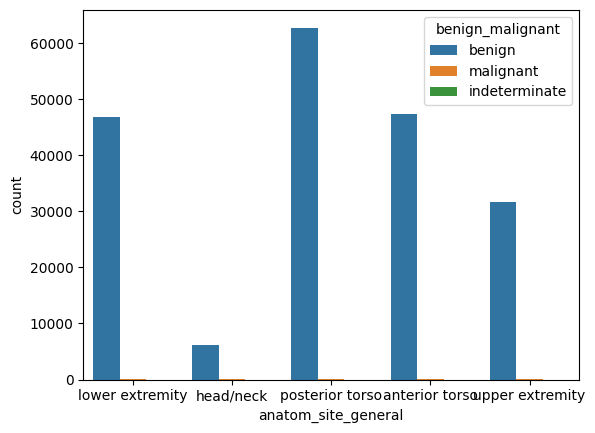

In [ ]:
sns.countplot(x = 'anatom_site_general', hue = 'benign_malignant', data = older_df)
plt.show()

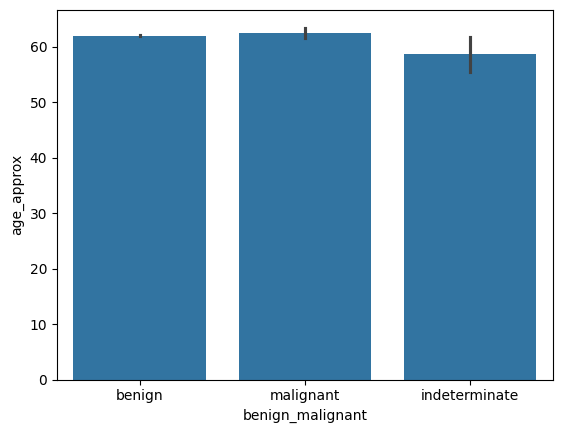

In [ ]:
sns.barplot(x = 'benign_malignant', y = 'age_approx', data = older_df)
plt.show()

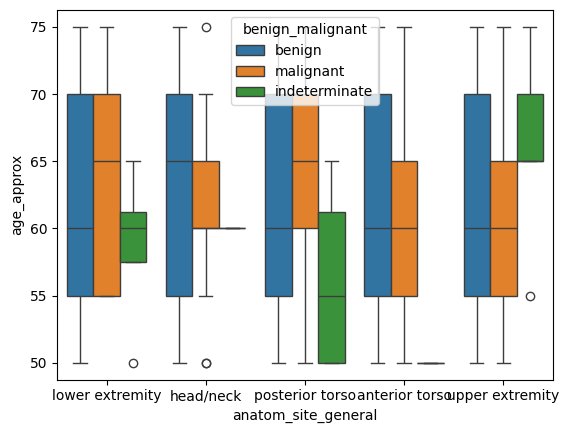

In [ ]:
sns.boxplot(x = 'anatom_site_general', y = 'age_approx', hue = 'benign_malignant', data = older_df)
plt.show()

# Younger CNN Model

In [ ]:
import zipfile
import pandas as pd
import os

uploaded_zip_path = '/content/combined_young_images.zip'  # path to uploaded zip file
extracted_dir = '/content/extracted_images'  # directory to extract images
metadata_path = '/content/combined_young_metadata.csv'  # path to uploaded metadata csv

# extract the zip file
os.makedirs(extracted_dir, exist_ok=True)
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Extracted images to: {extracted_dir}")

# load metadata
metadata = pd.read_csv(metadata_path)
print(metadata.head())


Extracted images to: /content/extracted_images
        isic_id  age_approx anatom_site_general benign_malignant  \
0  ISIC_0052259        45.0      anterior torso           benign   
1  ISIC_0052310        45.0     posterior torso           benign   
2  ISIC_0073521        40.0      anterior torso           benign   
3  ISIC_0073522        30.0      anterior torso           benign   
4  ISIC_0073642        45.0     upper extremity           benign   

                      file_path  target filename parent_image  
0  ISIC-images/ISIC_0052259.jpg     0.0      NaN          NaN  
1  ISIC-images/ISIC_0052310.jpg     0.0      NaN          NaN  
2  ISIC-images/ISIC_0073521.jpg     0.0      NaN          NaN  
3  ISIC-images/ISIC_0073522.jpg     0.0      NaN          NaN  
4  ISIC-images/ISIC_0073642.jpg     0.0      NaN          NaN  


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

metadata = pd.read_csv('/content/updated_young_metadata.csv')

print(metadata.head())
print(metadata['label'].value_counts())


        isic_id  age_approx anatom_site_general benign_malignant  \
0  ISIC_0052259        45.0      anterior torso           benign   
1  ISIC_0052310        45.0     posterior torso           benign   
2  ISIC_0073521        40.0      anterior torso           benign   
3  ISIC_0073522        30.0      anterior torso           benign   
4  ISIC_0073642        45.0     upper extremity           benign   

                                    file_path  target filename parent_image  \
0  /content/extracted_images/ISIC_0052259.jpg     0.0      NaN          NaN   
1  /content/extracted_images/ISIC_0052310.jpg     0.0      NaN          NaN   
2  /content/extracted_images/ISIC_0073521.jpg     0.0      NaN          NaN   
3  /content/extracted_images/ISIC_0073522.jpg     0.0      NaN          NaN   
4  /content/extracted_images/ISIC_0073642.jpg     0.0      NaN          NaN   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  
label
0    42257
1    11721
Name: count, dtype: in

In [ ]:
# convert labels to strings
train_df = pd.DataFrame({'file_path': train_paths, 'label': train_labels.astype(str)})
val_df = pd.DataFrame({'file_path': val_paths, 'label': val_labels.astype(str)})
test_df = pd.DataFrame({'file_path': test_paths, 'label': test_labels.astype(str)})

# training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path', y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)

# validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path', y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)

# test generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path', y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)


Found 34545 validated image filenames belonging to 2 classes.
Found 8637 validated image filenames belonging to 2 classes.
Found 10796 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# load ResNet50 as base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# freeze the layers of ResNet50 to prevent them from being trained
base_model.trainable = False

# add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # dropout layer to reduce overfitting
x = Dense(512, activation='relu')(x)  # dense layer
x = Dropout(0.5)(x)  # dropout layer again
predictions = Dense(1, activation='sigmoid')(x)  # sigmoid for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_young_model.keras', monitor='val_loss', save_best_only=True)

# train
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 462s 412ms/step - accuracy: 0.7470 - loss: 0.6019 - val_accuracy: 0.7828 - val_loss: 0.5503
Epoch 2/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 434s 400ms/step - accuracy: 0.7795 - loss: 0.5283 - val_accuracy: 0.7828 - val_loss: 0.5600
Epoch 3/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 436s 401ms/step - accuracy: 0.7821 - loss: 0.5131 - val_accuracy: 0.7985 - val_loss: 0.5572
Epoch 4/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 440s 400ms/step - accuracy: 0.7871 - loss: 0.5016 - val_accuracy: 0.8043 - val_loss: 0.5098
Epoch 5/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 434s 400ms/step - accuracy: 0.7898 - loss: 0.4890 - val_accuracy: 0.8429 - val_loss: 0.5504
Epoch 6/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 440s 398ms/step - accuracy: 0.7957 - loss: 0.4789 - val_accuracy: 0.8350 - val_loss: 0.5153
Epoch 7/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 451s 406ms/step - accuracy: 0.8026 - loss: 0.4683 - val_accuracy: 0.8518 - val_loss: 0.5504
Epoch 8/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 435s 401ms/step - accuracy: 0.8

In [ ]:
# convert test labels to strings
test_labels = test_labels.astype(str)

# create the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'file_path': test_paths, 'label': test_labels}),
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 10796 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.85      0.96      0.90      8452
   Malignant       0.75      0.41      0.53      2344

    accuracy                           0.84     10796
   macro avg       0.80      0.68      0.72     10796
weighted avg       0.83      0.84      0.82     10796


Confusion Matrix:
[[8129  323]
 [1388  956]]


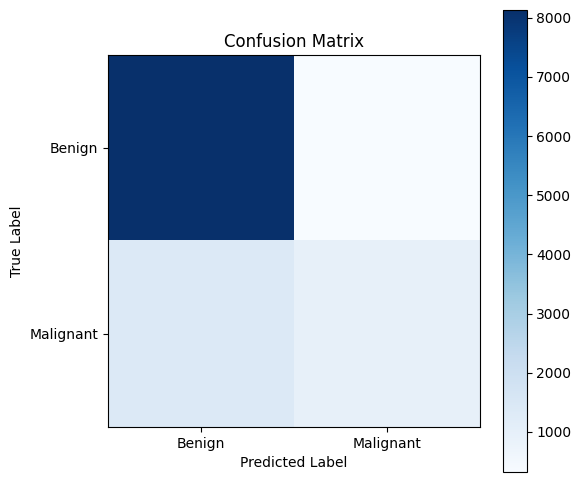

Test Accuracy: 0.8415


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# load the saved model
model = load_model('resnet50_young_model.keras')

# predict on the test set
predictions = model.predict(test_generator, verbose=1)

# convert probabilities to binary predictions
predicted_labels = (predictions > 0.5).astype(int)

# true labels from the generator
true_labels = test_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'])
plt.yticks(ticks=[0, 1], labels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# calculate accuracy
accuracy = np.mean(predicted_labels.flatten() == true_labels)
print(f"Test Accuracy: {accuracy:.4f}")


Sensitivity, Specificity, AUC

In [ ]:
from tensorflow.keras.models import load_model

# load the saved model
model = load_model('/content/resnet50_young_model.keras')


In [ ]:
malignant_test_samples = metadata[(metadata['label'] == 1) & (metadata['file_path'].isin(test_paths))]
print("Malignant samples in the test set:", len(malignant_test_samples))

Malignant samples in the test set: 2344


338/338 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step
Sensitivity (Recall): 0.41
Specificity: 0.96
AUC: 0.91


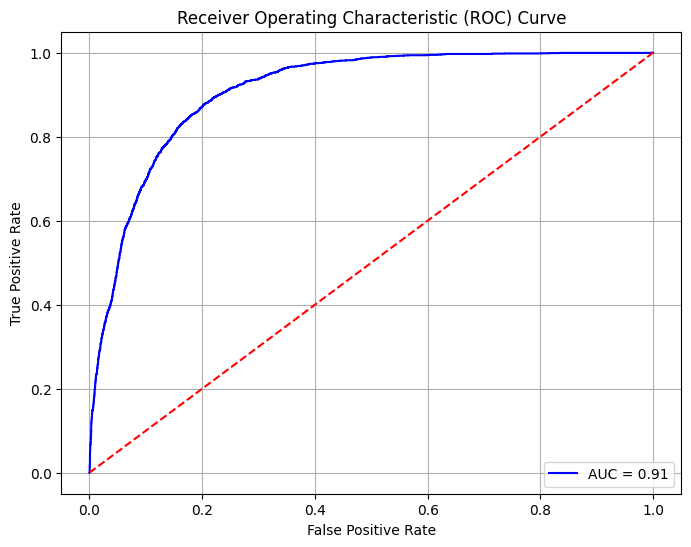

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# predict probabilities on the test set
y_pred_probs = model.predict(test_generator)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# true labels
y_true = test_generator.classes

# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()

# Sensitivity
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# AUC calculation
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUC: {roc_auc:.2f}")

# plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Grad-CAM

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/resnet50_young_model.keras')


In [ ]:
import zipfile
import pandas as pd
import os

uploaded_zip_path = '/content/combined_young_images.zip'  # path to uploaded zip file
extracted_young_dir = '/content/extracted_young_images'  # directory to extract images
metadata_path = '/content/combined_young_metadata.csv'  # path to uploaded metadata csv

# extract the zip file
os.makedirs(extracted_young_dir, exist_ok=True)
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_young_dir)

print(f"Extracted images to: {extracted_young_dir}")

# load metadata
metadata = pd.read_csv(metadata_path)
print(metadata.head())



Extracted images to: /content/extracted_young_images
        isic_id  age_approx anatom_site_general benign_malignant  \
0  ISIC_0052259        45.0      anterior torso           benign   
1  ISIC_0052310        45.0     posterior torso           benign   
2  ISIC_0073521        40.0      anterior torso           benign   
3  ISIC_0073522        30.0      anterior torso           benign   
4  ISIC_0073642        45.0     upper extremity           benign   

                      file_path  target filename parent_image  
0  ISIC-images/ISIC_0052259.jpg     0.0      NaN          NaN  
1  ISIC-images/ISIC_0052310.jpg     0.0      NaN          NaN  
2  ISIC-images/ISIC_0073521.jpg     0.0      NaN          NaN  
3  ISIC-images/ISIC_0073522.jpg     0.0      NaN          NaN  
4  ISIC-images/ISIC_0073642.jpg     0.0      NaN          NaN  


In [ ]:
print(metadata['benign_malignant'].unique())

['benign' 'indeterminate' 'malignant']


In [ ]:
metadata = metadata[metadata['benign_malignant'].isin(['benign', 'malignant'])]

In [ ]:
# ensure 'filename' is treated as a string
metadata['filename'] = metadata['filename'].astype(str)

# fill missing 'file_path' using the 'filename' column
augmented_images_dir = '/content/extracted_young_images'
metadata['file_path'] = metadata['file_path'].fillna(
    metadata['filename'].apply(lambda x: os.path.join(augmented_images_dir, x) if pd.notnull(x) else None)
)

In [ ]:
# correct the file paths by removing the 'ISIC-images/' part
metadata['file_path'] = metadata['file_path'].str.replace('ISIC-images/', '', regex=False)
metadata['file_path'] = metadata['file_path'].apply(
    lambda x: os.path.join('/content/extracted_young_images', x) if pd.notnull(x) else x
)

print(metadata['file_path'].head())

0    /content/extracted_young_images/ISIC_0052259.jpg
1    /content/extracted_young_images/ISIC_0052310.jpg
2    /content/extracted_young_images/ISIC_0073521.jpg
3    /content/extracted_young_images/ISIC_0073522.jpg
4    /content/extracted_young_images/ISIC_0073642.jpg
Name: file_path, dtype: object


In [ ]:
# choose a specific image from the test dataset
test_image_path = metadata['file_path'].iloc[127]
print(f"Selected test image path: {test_image_path}")

Selected test image path: /content/extracted_young_images/ISIC_0101423.jpg


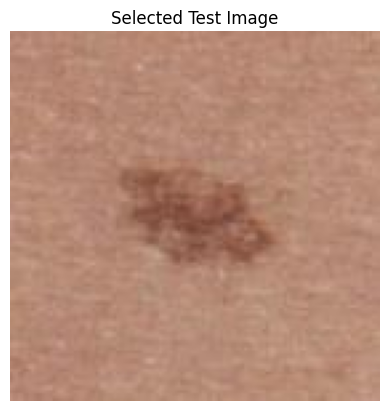

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# load and display the test image
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Selected Test Image')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

IMG_HEIGHT = 224
IMG_WIDTH = 224

# load and preprocess the image
img = Image.open(test_image_path).resize((IMG_WIDTH, IMG_HEIGHT))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

print(f"Processed image shape: {img_array.shape}")


Processed image shape: (1, 224, 224, 3)


In [ ]:
from tensorflow.keras.models import load_model

# load trained model
model_path = '/content/resnet50_young_model.keras'
model = load_model(model_path)

# predict
prediction = model.predict(img_array)
predicted_class = 1 if prediction[0] > 0.5 else 0  # Assuming binary classification (0 or 1)

print(f"Prediction: {prediction[0]}")
print(f"Predicted Class: {'Malignant' if predicted_class == 1 else 'Benign'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: [0.31178534]
Predicted Class: Benign


In [ ]:
# inspect model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,736,517 (101.99 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2,099,204 (8.01 MB)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# load trained model
model_path = '/content/resnet50_young_model.keras'
model = tf.keras.models.load_model(model_path)

# identify the last convolutional layer
last_conv_layer_name = 'conv5_block3_out'

# create a model that outputs both the last convolutional layer's activations and the model's predictions
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)


In [ ]:
# Grad-CAM
def compute_gradcam(model, img_array, conv_layer_name):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = predictions[0]
        tape.watch(conv_output)
        class_gradients = tape.gradient(predicted_class, conv_output)

    # pool the gradients by averaging them across spatial dimensions
    pooled_gradients = tf.reduce_mean(class_gradients, axis=(0, 1, 2))

    # multiply the pooled gradients with the convolutional layer output
    conv_output = conv_output[0]  # Remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_gradients, conv_output), axis=-1)

    # normalize the heatmap to [0, 1]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# preprocess the test image
IMG_HEIGHT = 224  # Update with your image size
IMG_WIDTH = 224   # Update with your image size

# load and resize the test image
img = Image.open(test_image_path).resize((IMG_WIDTH, IMG_HEIGHT))
img_array = np.expand_dims(np.array(img) / 255.0, axis=0)  # Normalize and add batch dimension

# compute Grad-CAM heatmap
heatmap = compute_gradcam(grad_model, img_array, last_conv_layer_name)


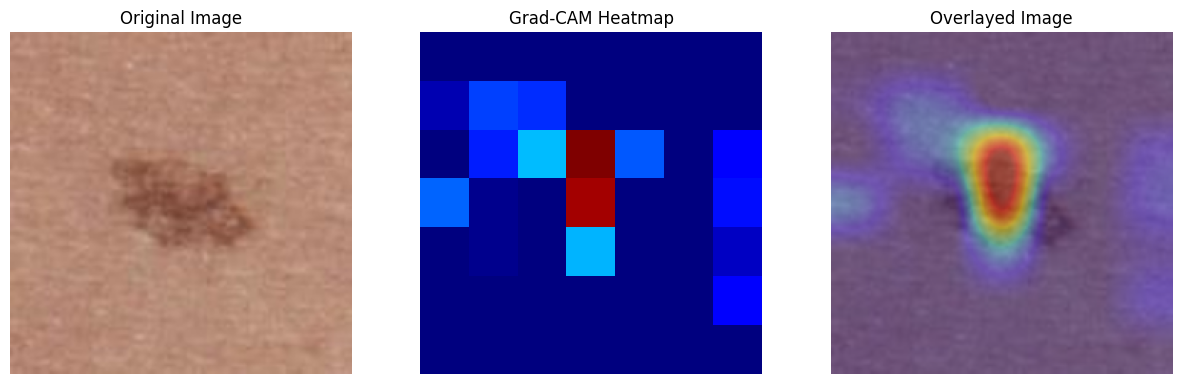

In [ ]:
# overlay heatmap on the original image
def overlay_heatmap(heatmap, img, alpha=0.4, colormap=plt.cm.jet):
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize((img.size[0], img.size[1]))
    heatmap = np.array(heatmap)
    heatmap_colored = colormap(heatmap / 255.0)[:, :, :3]

    # overlay heatmap on the original image
    overlayed_image = np.array(img) / 255.0
    overlayed_image = alpha * heatmap_colored + (1 - alpha) * overlayed_image
    overlayed_image = np.clip(overlayed_image, 0, 1)
    return overlayed_image

# overlay the heatmap on the original image
overlayed_image = overlay_heatmap(heatmap, img)

# plot the original image, heatmap, and overlayed image
plt.figure(figsize=(15, 5))

# display Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

# display Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('Grad-CAM Heatmap')

# display Image with Heatmap Overlay
plt.subplot(1, 3, 3)
plt.imshow(overlayed_image)
plt.axis('off')
plt.title('Overlayed Image')

plt.show()


In [ ]:
image_index = 127

# get true label for index image
correct_label = metadata['target'].iloc[image_index]

print(f"The correct label for the image {test_image_path} is: {correct_label}")


The correct label for the image /content/extracted_young_images/ISIC_0101423.jpg is: 0.0


# Older CNN Model

In [ ]:
import zipfile
import pandas as pd
import os

uploaded_zip_path = '/content/combined_old_images.zip'  # path to uploaded zip file
extracted_dir = '/content/extracted_images'  # directory to extract images
metadata_path = '/content/combined_old_metadata.csv'  # path to uploaded metadata csv

# Extract the zip file
os.makedirs(extracted_dir, exist_ok=True)
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Extracted images to: {extracted_dir}")

# load metadata
metadata = pd.read_csv(metadata_path)
print(metadata.head())

Extracted images to: /content/extracted_images
        isic_id  age_approx anatom_site_general benign_malignant  \
0  ISIC_0015670        60.0     lower extremity           benign   
1  ISIC_0015845        60.0           head/neck           benign   
2  ISIC_0015864        60.0     posterior torso           benign   
3  ISIC_0015902        65.0      anterior torso           benign   
4  ISIC_0024200        55.0      anterior torso           benign   

                      file_path  target filename parent_image  
0  ISIC-images/ISIC_0015670.jpg     0.0      NaN          NaN  
1  ISIC-images/ISIC_0015845.jpg     0.0      NaN          NaN  
2  ISIC-images/ISIC_0015864.jpg     0.0      NaN          NaN  
3  ISIC-images/ISIC_0015902.jpg     0.0      NaN          NaN  
4  ISIC-images/ISIC_0024200.jpg     0.0      NaN          NaN  


<ipython-input-56-091fd3da239a>:17: DtypeWarning: Columns (0,2,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [ ]:
metadata = pd.read_csv('/content/combined_old_metadata.csv')

<ipython-input-4-985f643e3a54>:1: DtypeWarning: Columns (0,2,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/combined_old_metadata.csv')


In [ ]:
print(metadata['file_path'].isnull().sum())

21608


In [ ]:
print(metadata['benign_malignant'].unique())

['benign' 'malignant' 'indeterminate']


In [ ]:
metadata = metadata[metadata['benign_malignant'].isin(['benign', 'malignant'])]

In [ ]:
# make benign_malignant into binary
metadata['label'] = metadata['benign_malignant'].map({'benign': 0, 'malignant': 1})
print(metadata['label'].isnull().sum())  # Should be 0

0


In [ ]:
# ensure 'filename' is treated as a string
metadata['filename'] = metadata['filename'].astype(str)

# fill missing 'file_path' using the 'filename' column
augmented_images_dir = '/content/extracted_images'
metadata['file_path'] = metadata['file_path'].fillna(
    metadata['filename'].apply(lambda x: os.path.join(augmented_images_dir, x) if pd.notnull(x) else None)
)

In [ ]:
# correct the file paths by removing the 'ISIC-images/' part
metadata['file_path'] = metadata['file_path'].str.replace('ISIC-images/', '', regex=False)
metadata['file_path'] = metadata['file_path'].apply(
    lambda x: os.path.join('/content/extracted_images', x) if pd.notnull(x) else x
)

print(metadata['file_path'].head())

0    /content/extracted_images/ISIC_0015670.jpg
1    /content/extracted_images/ISIC_0015845.jpg
2    /content/extracted_images/ISIC_0015864.jpg
3    /content/extracted_images/ISIC_0015902.jpg
4    /content/extracted_images/ISIC_0024200.jpg
Name: file_path, dtype: object


In [ ]:
# ensure 'file_path' is treated as a string
metadata['file_path'] = metadata['file_path'].astype(str)

# split the data into training + validation (80%) and test (20%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    metadata['file_path'], metadata['label'], test_size=0.2, random_state=42, stratify=metadata['label']
)

# split training + validation into training (80%) and validation (20%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, random_state=42, stratify=train_val_labels
)

# check the class distribution
print("Training set distribution:", pd.Series(train_labels).value_counts())
print("Validation set distribution:", pd.Series(val_labels).value_counts())
print("Test set distribution:", pd.Series(test_labels).value_counts())

Training set distribution: label
0    124653
1     13968
Name: count, dtype: int64
Validation set distribution: label
0    31164
1     3492
Name: count, dtype: int64
Test set distribution: label
0    38955
1     4365
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# convert labels to strings
train_df = pd.DataFrame({'file_path': train_paths, 'label': train_labels.astype(str)})
val_df = pd.DataFrame({'file_path': val_paths, 'label': val_labels.astype(str)})
test_df = pd.DataFrame({'file_path': test_paths, 'label': test_labels.astype(str)})

# data generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path', y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path', y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary'
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path', y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

Found 138621 validated image filenames belonging to 2 classes.
Found 34656 validated image filenames belonging to 2 classes.
Found 43320 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# load ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# freeze the layers of ResNet50 to prevent them from being trained
base_model.trainable = False

# add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(512, activation='relu')(x)  # Dense layer
x = Dropout(0.5)(x)  # Dropout layer again
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_old_model.keras', monitor='val_loss', save_best_only=True)

# train
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1360s 311ms/step - accuracy: 0.8957 - loss: 0.3560 - val_accuracy: 0.8992 - val_loss: 0.4150
Epoch 2/10
4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1342s 309ms/step - accuracy: 0.8984 - loss: 0.3257 - val_accuracy: 0.8996 - val_loss: 0.3755
Epoch 3/10
4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1330s 306ms/step - accuracy: 0.8989 - loss: 0.3162 - val_accuracy: 0.9000 - val_loss: 0.4154
Epoch 4/10
4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1319s 304ms/step - accuracy: 0.9002 - loss: 0.3072 - val_accuracy: 0.9023 - val_loss: 0.4005
Epoch 5/10
4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1318s 304ms/step - accuracy: 0.9009 - loss: 0.2997 - val_accuracy: 0.9008 - val_loss: 0.3102
Epoch 6/10
4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1320s 304ms/step - accuracy: 0.9008 - loss: 0.2954 - val_accuracy: 0.9030 - val_loss: 0.3367
Epoch 7/10
4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1321s 304ms/step - accuracy: 0.9025 - loss: 0.2870 - val_accuracy: 0.9036 - val_loss: 0.3124
Epoch 8/10
4332/4332 ━━━━━━━━━━━━━━━━━━━━ 1324s 305ms/step - accur

In [ ]:
#get predictions on test data
predictions = model.predict(test_generator, verbose=1)

# convert probabilities to class labels
predicted_classes = (predictions > 0.5).astype(int)

1354/1354 ━━━━━━━━━━━━━━━━━━━━ 108s 77ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import numpy as np

In [ ]:
true_labels = test_generator.labels

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print(f"Confusion Matrix:\n{conf_matrix}")

# accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy}")

# sensitivity
from sklearn.metrics import recall_score
sensitivity = recall_score(true_labels, predicted_classes)
print(f"Sensitivity: {sensitivity:.4f}")

# specificy
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

# AUC
auc = roc_auc_score(true_labels, predictions)
print(f"AUC: {auc:.4f}")


Confusion Matrix:
[[38126   829]
 [ 3243  1122]]
Accuracy: 0.9060018467220683
Sensitivity: 0.2570
Specificity: 0.9787
AUC: 0.8961


1354/1354 ━━━━━━━━━━━━━━━━━━━━ 109s 78ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.98      0.95     38955
   Malignant       0.58      0.26      0.36      4365

    accuracy                           0.91     43320
   macro avg       0.75      0.62      0.65     43320
weighted avg       0.89      0.91      0.89     43320


Confusion Matrix:
[[38126   829]
 [ 3243  1122]]


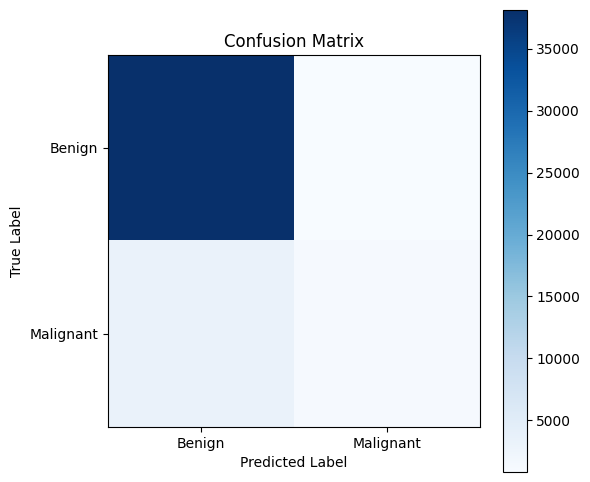

Test Accuracy: 0.9060


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# load the saved model
model = load_model('resnet50_old_model.keras')

# predict on the test set
predictions = model.predict(test_generator, verbose=1)

# convert probabilities to binary predictions
predicted_labels = (predictions > 0.5).astype(int)

# true labels from the generator
true_labels = test_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'])
plt.yticks(ticks=[0, 1], labels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# calculate accuracy
accuracy = np.mean(predicted_labels.flatten() == true_labels)
print(f"Test Accuracy: {accuracy:.4f}")

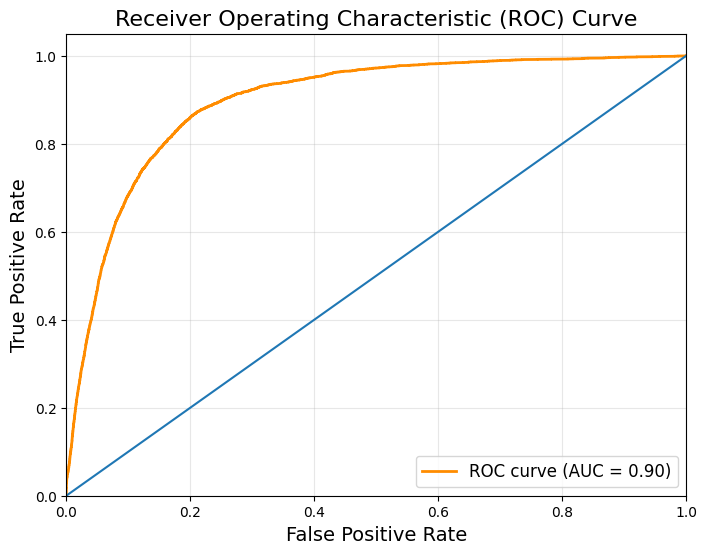

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# plot the curve
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 12)
plt.grid(alpha = 0.3)
plt.show()

# Grad-CAM Old

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/resnet50_old_model.keras')

In [ ]:
import zipfile
import pandas as pd
import os

uploaded_zip_path = '/content/combined_old_images.zip'  # path to uploaded zip file
extracted_old_dir = '/content/extracted_old_images'  # directory to extract images
metadata_path = '/content/combined_old_metadata.csv'  # path to uploaded metadata csv

# extract the zip file
os.makedirs(extracted_old_dir, exist_ok=True)
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_old_dir)

print(f"Extracted images to: {extracted_old_dir}")

# load metadata
metadata = pd.read_csv(metadata_path)
print(metadata.head())

Extracted images to: /content/extracted_old_images
        isic_id  age_approx anatom_site_general benign_malignant  \
0  ISIC_0015670        60.0     lower extremity           benign   
1  ISIC_0015845        60.0           head/neck           benign   
2  ISIC_0015864        60.0     posterior torso           benign   
3  ISIC_0015902        65.0      anterior torso           benign   
4  ISIC_0024200        55.0      anterior torso           benign   

                      file_path  target filename parent_image  
0  ISIC-images/ISIC_0015670.jpg     0.0      NaN          NaN  
1  ISIC-images/ISIC_0015845.jpg     0.0      NaN          NaN  
2  ISIC-images/ISIC_0015864.jpg     0.0      NaN          NaN  
3  ISIC-images/ISIC_0015902.jpg     0.0      NaN          NaN  
4  ISIC-images/ISIC_0024200.jpg     0.0      NaN          NaN  


<ipython-input-15-74d5136f549c>:17: DtypeWarning: Columns (0,2,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)


In [ ]:
print(metadata['benign_malignant'].unique())

['benign' 'malignant' 'indeterminate']


In [ ]:
metadata = metadata[metadata['benign_malignant'].isin(['benign', 'malignant'])]

In [ ]:
# ensure 'filename' is treated as a string
metadata['filename'] = metadata['filename'].astype(str)

# fill missing 'file_path' using the 'filename' column
augmented_images_dir = '/content/extracted_old_images'
metadata['file_path'] = metadata['file_path'].fillna(
    metadata['filename'].apply(lambda x: os.path.join(augmented_images_dir, x) if pd.notnull(x) else None)
)

In [ ]:
# correct the file paths by removing the 'ISIC-images/' part
metadata['file_path'] = metadata['file_path'].str.replace('ISIC-images/', '', regex=False)
metadata['file_path'] = metadata['file_path'].apply(
    lambda x: os.path.join('/content/extracted_old_images', x) if pd.notnull(x) else x
)

print(metadata['file_path'].head())

0    /content/extracted_old_images/ISIC_0015670.jpg
1    /content/extracted_old_images/ISIC_0015845.jpg
2    /content/extracted_old_images/ISIC_0015864.jpg
3    /content/extracted_old_images/ISIC_0015902.jpg
4    /content/extracted_old_images/ISIC_0024200.jpg
Name: file_path, dtype: object


In [ ]:
# choose a specific image from the test dataset
test_image_path = metadata['file_path'].iloc[77]
print(f"Selected test image path: {test_image_path}")

Selected test image path: /content/extracted_old_images/ISIC_0076969.jpg


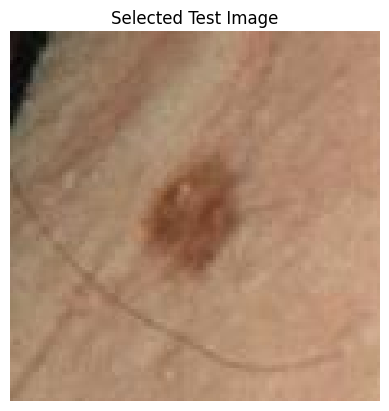

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# load and display the test image
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Selected Test Image')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

IMG_HEIGHT = 224
IMG_WIDTH = 224

# load and preprocess the image
img = Image.open(test_image_path).resize((IMG_WIDTH, IMG_HEIGHT))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

print(f"Processed image shape: {img_array.shape}")

Processed image shape: (1, 224, 224, 3)


In [ ]:
from tensorflow.keras.models import load_model

# load trained model
model_path = '/content/resnet50_old_model.keras'
model = load_model(model_path)

# make a prediction
prediction = model.predict(img_array)
predicted_class = 1 if prediction[0] > 0.5 else 0

print(f"Prediction: {prediction[0]}")
print(f"Predicted Class: {'Malignant' if predicted_class == 1 else 'Benign'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: [0.1648228]
Predicted Class: Benign


In [ ]:
# inspect model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,736,517 (101.99 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2,099,204 (8.01 MB)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# load trained model
model_path = '/content/resnet50_old_model.keras'
model = tf.keras.models.load_model(model_path)

# identify the last convolutional layer
last_conv_layer_name = 'conv5_block3_out'

# create a model that outputs both the last convolutional layer's activations and the model's predictions
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)

In [ ]:
# Grad-CAM
def compute_gradcam(model, img_array, conv_layer_name):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        predicted_class = predictions[0]
        tape.watch(conv_output)
        class_gradients = tape.gradient(predicted_class, conv_output)

    # pool the gradients by averaging them across spatial dimensions
    pooled_gradients = tf.reduce_mean(class_gradients, axis=(0, 1, 2))

    # multiply the pooled gradients with the convolutional layer output
    conv_output = conv_output[0]  # Remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_gradients, conv_output), axis=-1)

    # normalize the heatmap to [0, 1]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# preprocess the test image
IMG_HEIGHT = 224
IMG_WIDTH = 224

# load and resize the test image
img = Image.open(test_image_path).resize((IMG_WIDTH, IMG_HEIGHT))
img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

# compute Grad-CAM heatmap
heatmap = compute_gradcam(grad_model, img_array, last_conv_layer_name)

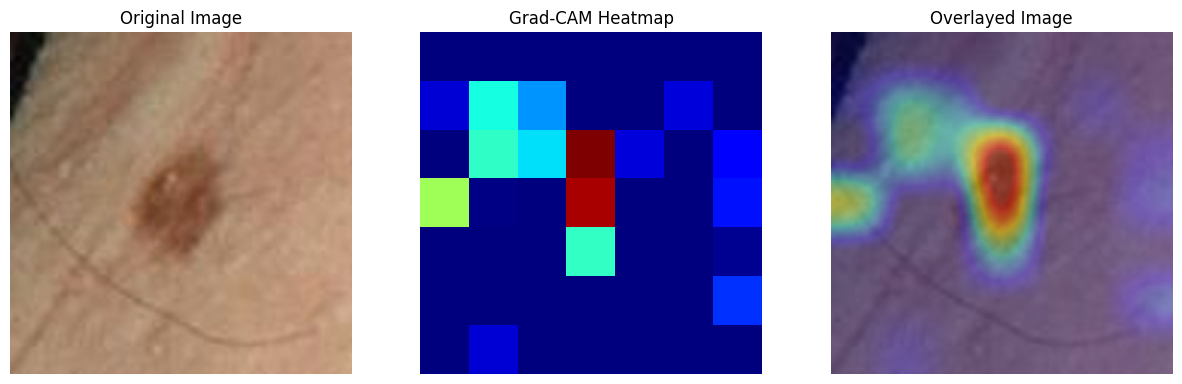

In [ ]:
# overlay heatmap on the original image
def overlay_heatmap(heatmap, img, alpha=0.4, colormap=plt.cm.jet):
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize((img.size[0], img.size[1]))
    heatmap = np.array(heatmap)
    heatmap_colored = colormap(heatmap / 255.0)[:, :, :3]

    # overlay heatmap on the original image
    overlayed_image = np.array(img) / 255.0
    overlayed_image = alpha * heatmap_colored + (1 - alpha) * overlayed_image
    overlayed_image = np.clip(overlayed_image, 0, 1)
    return overlayed_image

# overlay the heatmap on the original image
overlayed_image = overlay_heatmap(heatmap, img)

# plot the original image, heatmap, and overlayed image
plt.figure(figsize=(15, 5))

# display Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

# display Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('Grad-CAM Heatmap')

# display Image with Heatmap Overlay
plt.subplot(1, 3, 3)
plt.imshow(overlayed_image)
plt.axis('off')
plt.title('Overlayed Image')

plt.show()


In [ ]:
image_index = 77  # Update this with the index of your selected image

# get true label of index image
correct_label = metadata['target'].iloc[image_index]

print(f"The correct label for the image {test_image_path} is: {correct_label}")

The correct label for the image /content/extracted_old_images/ISIC_0076969.jpg is: 0.0
